## Set-up

In [17]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sys

# Import cv2 for video processing
try:
    import cv2
except ImportError:
    print("OpenCV not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python"])
    import cv2

In [18]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


### Loading the SAM 2 video predictor

In [19]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [20]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

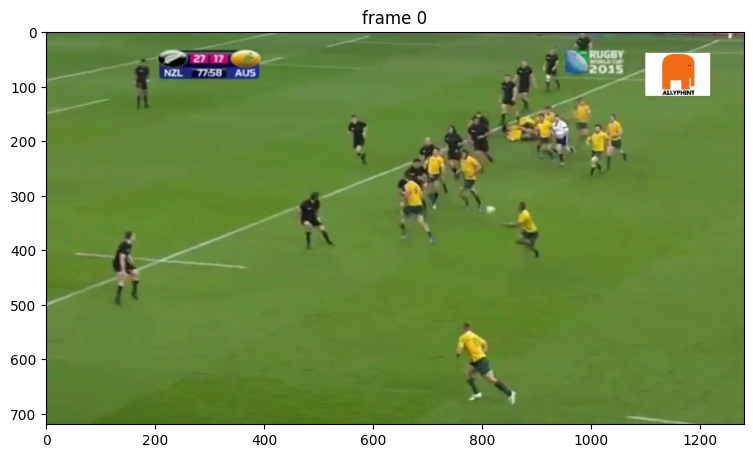

In [21]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/rugby"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [22]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 461/461 [00:16<00:00, 28.26it/s]



### Process 4 Rugby Scenes with Individual Initialization

We'll process 4 different rugby scenes (rugby1, rugby2, rugby3, rugby4) with separate initialization for each scene. Each scene will have its own inference state, tracking coordinates, and saved output video.

In [23]:
# Configuration for 4 rugby scenes
rugby_scenes = {
    "rugby1": {
        "video_dir": "./videos/rugby1",
        "coordinates": np.array([[145.3924731182796, 416.7559139784947]], dtype=np.float32),  # Replace with your actual coordinates
        "frame_idx": 0  # Frame to click on
    },
    "rugby2": {
        "video_dir": "./videos/rugby2", 
        "coordinates": np.array([[701.4354838709678, 368.3086021505377]], dtype=np.float32),  # Replace with your actual coordinates
        "frame_idx": 0  # Frame to click on
    },
    "rugby3": {
        "video_dir": "./videos/rugby3",
        "coordinates": np.array([[309.452688172043, 403.54301075268825]], dtype=np.float32),  # Replace with your actual coordinates
        "frame_idx": 0  # Frame to click on
    },
    "rugby4": {
        "video_dir": "./videos/rugby4",
        "coordinates": np.array([[513.1516129032259, 338.57956989247316]], dtype=np.float32),  # Replace with your actual coordinates
        "frame_idx": 0  # Frame to click on
    }
}

print("Scene configuration loaded for 4 rugby scenes")
print("Note: Please update the coordinates above with your actual tracking coordinates for each scene")

Scene configuration loaded for 4 rugby scenes
Note: Please update the coordinates above with your actual tracking coordinates for each scene


In [24]:
def process_rugby_scene(scene_name, scene_config, predictor, device):
    """
    Process a single rugby scene with individual initialization
    """
    print(f"\n=== Processing {scene_name} ===")
    
    # Get scene configuration
    video_dir = scene_config["video_dir"]
    coordinates = scene_config["coordinates"]
    ann_frame_idx = scene_config["frame_idx"]
    
    # Check if video directory exists
    if not os.path.exists(video_dir):
        print(f"Warning: Video directory {video_dir} does not exist. Skipping {scene_name}")
        return None
    
    # Scan all JPEG frame names in this directory
    frame_names = [
        p for p in os.listdir(video_dir)
        if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
    ]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
    
    if not frame_names:
        print(f"Warning: No JPEG frames found in {video_dir}. Skipping {scene_name}")
        return None
    
    print(f"Found {len(frame_names)} frames in {video_dir}")
    
    # Initialize inference state for this scene
    print(f"Initializing inference state for {scene_name}...")
    inference_state = predictor.init_state(video_path=video_dir)
    
    # Reset state to ensure clean start
    predictor.reset_state(inference_state)
    
    # Add tracking point
    ann_obj_id = 1  # Object ID for tracking
    labels = np.array([1], np.int32)  # Positive click
    
    print(f"Adding tracking point at {coordinates[0]} on frame {ann_frame_idx}")
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=coordinates,
        labels=labels,
    )
    
    # Show the initial tracking result
    plt.figure(figsize=(9, 6))
    plt.title(f"{scene_name} - Initial tracking on frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    show_points(coordinates, labels, plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
    plt.show()
    
    # Propagate tracking throughout the video
    print(f"Propagating tracking for {scene_name}...")
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    
    print(f"Completed tracking for {scene_name}: {len(video_segments)} frames processed")
    
    # Visualize some sample frames
    vis_frame_stride = max(1, len(frame_names) // 6)  # Show about 6 sample frames
    plt.close("all")
    for sample_idx, out_frame_idx in enumerate(range(0, len(frame_names), vis_frame_stride)):
        if out_frame_idx in video_segments and sample_idx < 6:  # Limit to 6 visualizations
            plt.figure(figsize=(6, 4))
            plt.title(f"{scene_name} - frame {out_frame_idx}")
            plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
            for out_obj_id, out_mask in video_segments[out_frame_idx].items():
                show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
            plt.show()
    
    return {
        "scene_name": scene_name,
        "video_segments": video_segments,
        "frame_names": frame_names,
        "video_dir": video_dir
    }

print("Scene processing function defined")

Scene processing function defined


In [25]:
def save_rugby_scene_video(scene_result, output_fps=30.0):
    """
    Save a rugby scene with segmentation masks as a video file
    """
    if scene_result is None:
        return
    
    scene_name = scene_result["scene_name"]
    video_segments = scene_result["video_segments"]
    frame_names = scene_result["frame_names"]
    video_dir = scene_result["video_dir"]
    
    output_path = f"{scene_name}_segmentation.mp4"
    
    # Import cv2 if not already imported
    try:
        import cv2
    except ImportError:
        print("OpenCV not found. Installing...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python"])
        import cv2
    
    # Get first frame to determine video properties
    first_frame = cv2.imread(os.path.join(video_dir, frame_names[0]))
    if first_frame is None:
        print(f"❌ Could not read first frame from {video_dir}")
        return None
        
    height, width, channels = first_frame.shape
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, output_fps, (width, height))
    
    print(f"Saving {scene_name} video...")
    
    for frame_idx in range(len(frame_names)):
        # Read original frame
        frame = cv2.imread(os.path.join(video_dir, frame_names[frame_idx]))
        if frame is None:
            print(f"⚠️ Could not read frame {frame_idx}, skipping...")
            continue
            
        # Add masks if available for this frame
        if frame_idx in video_segments:
            for obj_id, mask in video_segments[frame_idx].items():
                try:
                    # Ensure mask is 2D and matches frame dimensions
                    if mask.ndim > 2:
                        mask = mask.squeeze()
                    
                    # Resize mask if dimensions don't match
                    if mask.shape != (height, width):
                        print(f"⚠️ Mask shape {mask.shape} doesn't match frame shape ({height}, {width}). Resizing...")
                        mask = cv2.resize(mask.astype(np.uint8), (width, height), interpolation=cv2.INTER_NEAREST).astype(bool)
                    
                    # Create colored mask overlay
                    cmap = plt.get_cmap("tab10")
                    color = np.array([*cmap(obj_id)[:3], 0.6])
                    mask_colored = np.zeros((height, width, 3), dtype=np.uint8)
                    
                    # Apply mask safely
                    if mask.shape == (height, width):
                        mask_colored[mask] = (color[:3] * 255).astype(np.uint8)
                        # Blend with original frame
                        frame = cv2.addWeighted(frame, 0.7, mask_colored, 0.3, 0)
                    else:
                        print(f"⚠️ Skipping mask for frame {frame_idx} due to dimension mismatch")
                        
                except Exception as e:
                    print(f"⚠️ Error applying mask for frame {frame_idx}: {str(e)}")
                    continue
        
        out.write(frame)
    
    out.release()
    print(f"✅ Video saved: {output_path}")
    return output_path

print("Video saving function defined")

Video saving function defined


🚀 Starting processing of 4 rugby scenes...

=== Processing rugby1 ===
Found 120 frames in ./videos/rugby1
Initializing inference state for rugby1...


frame loading (JPEG): 100%|██████████| 120/120 [00:05<00:00, 20.09it/s]



Adding tracking point at [145.39247 416.75592] on frame 0


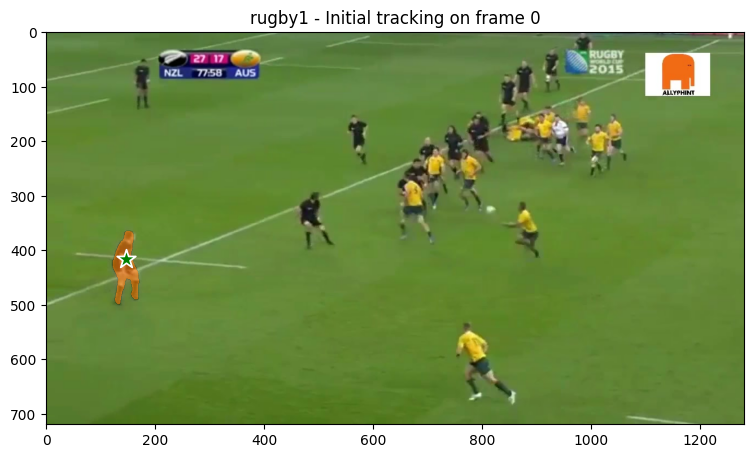

Propagating tracking for rugby1...


propagate in video: 100%|██████████| 120/120 [19:41<00:00,  9.85s/it]  



Completed tracking for rugby1: 120 frames processed


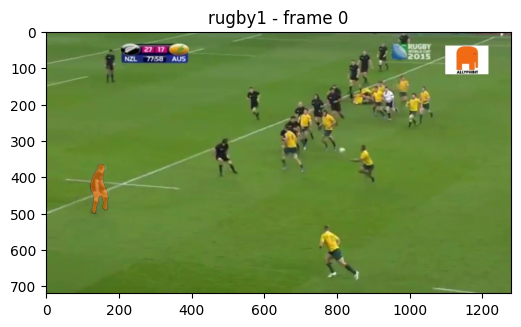

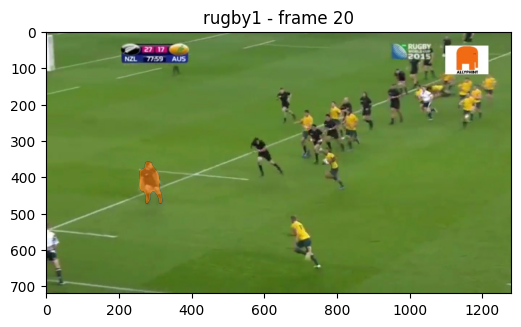

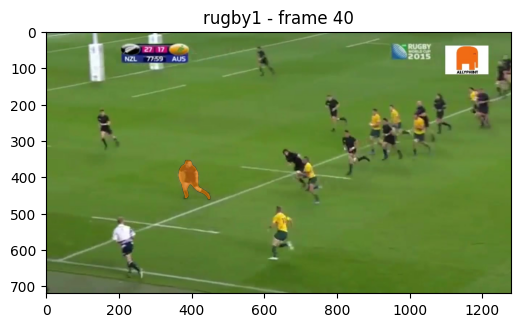

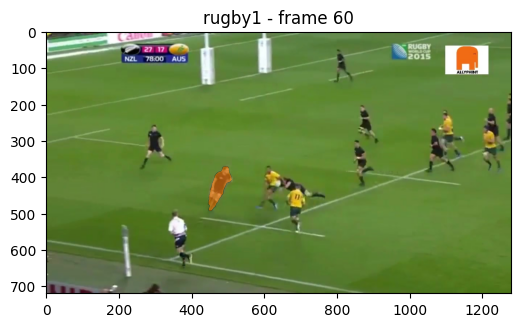

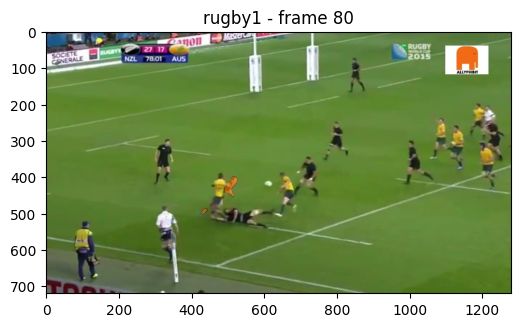

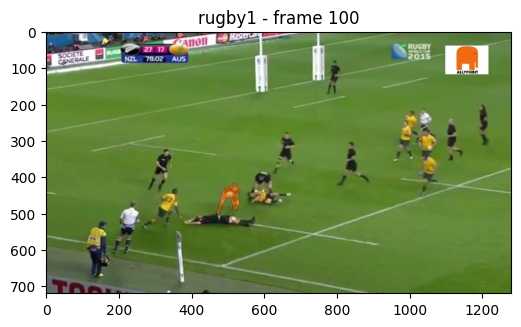

Saving rugby1 video...
❌ Error processing rugby1: boolean index did not match indexed array along axis 0; size of axis is 720 but size of corresponding boolean axis is 1
----------------------------------------

=== Processing rugby2 ===
Found 105 frames in ./videos/rugby2
Initializing inference state for rugby2...


frame loading (JPEG): 100%|██████████| 105/105 [00:04<00:00, 24.56it/s]



Adding tracking point at [701.4355 368.3086] on frame 0


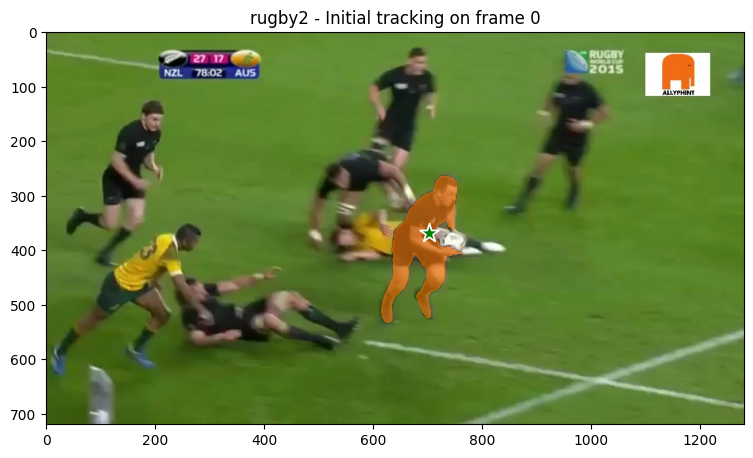

Propagating tracking for rugby2...


propagate in video: 100%|██████████| 105/105 [12:58<00:00,  7.42s/it]



Completed tracking for rugby2: 105 frames processed


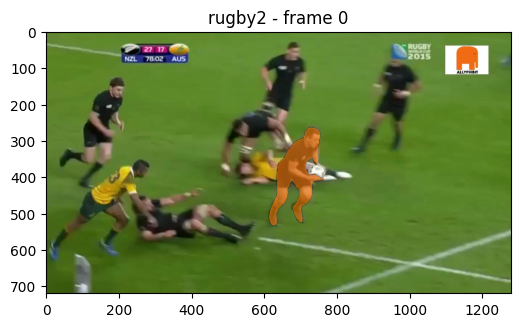

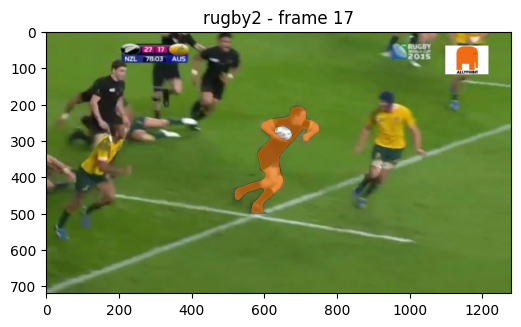

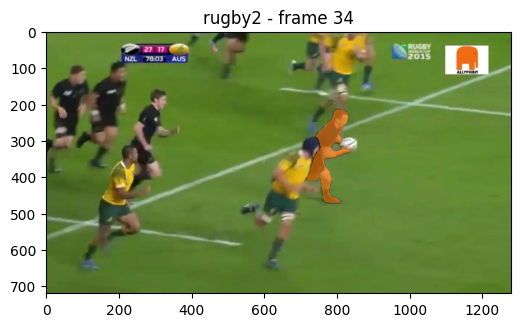

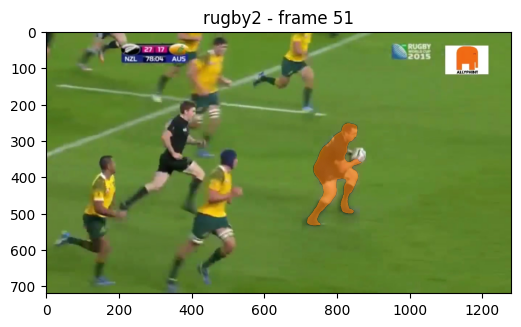

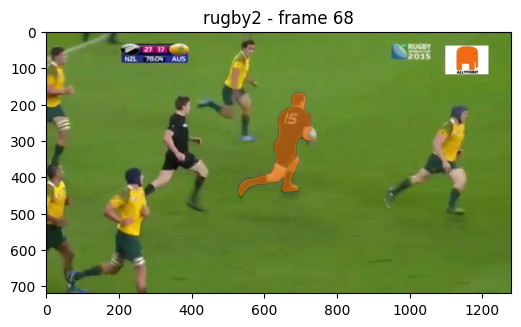

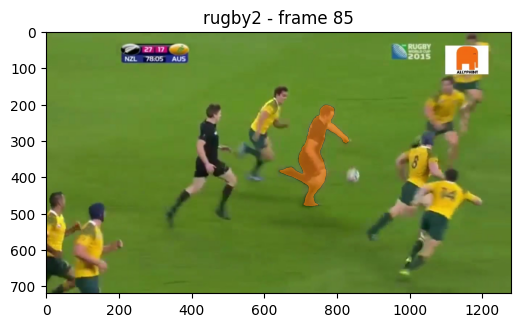

Saving rugby2 video...
❌ Error processing rugby2: boolean index did not match indexed array along axis 0; size of axis is 720 but size of corresponding boolean axis is 1
----------------------------------------

=== Processing rugby3 ===
Found 192 frames in ./videos/rugby3
Initializing inference state for rugby3...


frame loading (JPEG): 100%|██████████| 192/192 [00:07<00:00, 25.07it/s]



Adding tracking point at [309.4527 403.543 ] on frame 0


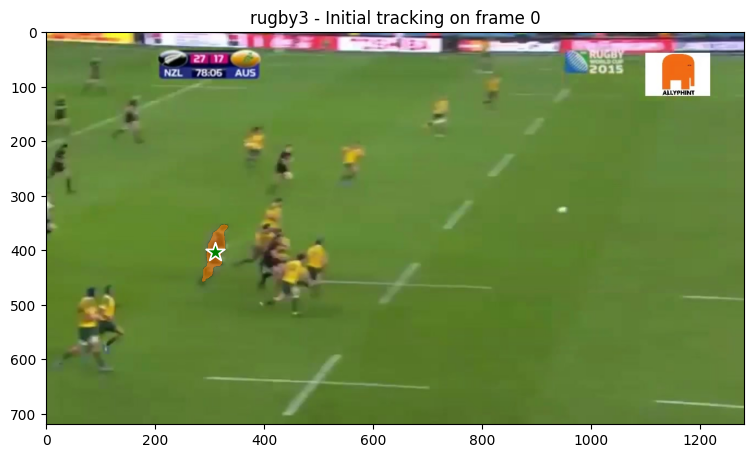

Propagating tracking for rugby3...


propagate in video: 100%|██████████| 192/192 [26:09<00:00,  8.18s/it]


Completed tracking for rugby3: 192 frames processed


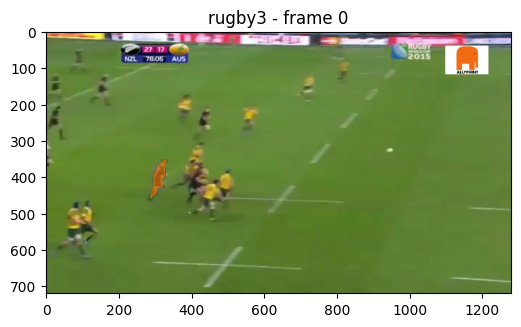

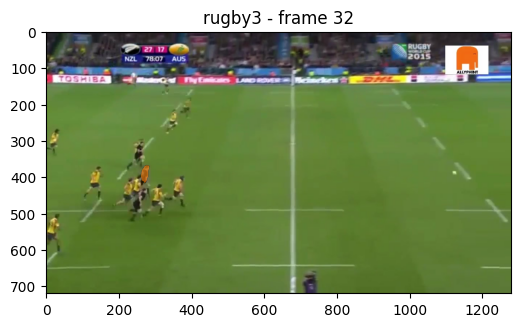

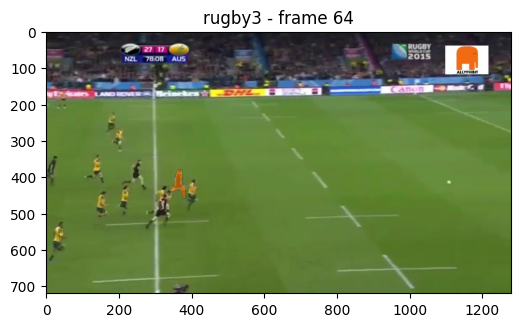

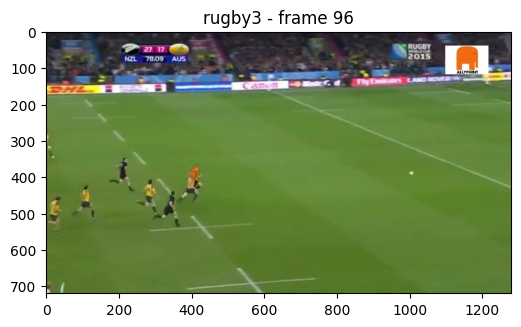

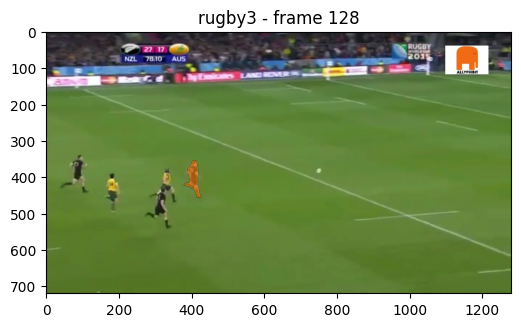

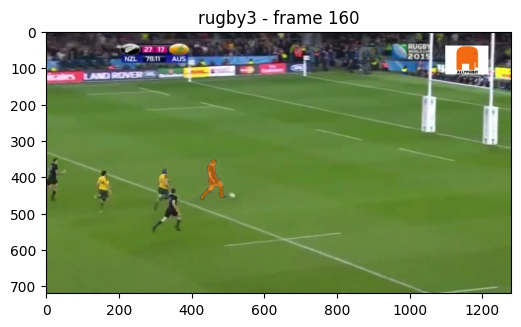

Saving rugby3 video...
❌ Error processing rugby3: boolean index did not match indexed array along axis 0; size of axis is 720 but size of corresponding boolean axis is 1
----------------------------------------

=== Processing rugby4 ===
Found 44 frames in ./videos/rugby4
Initializing inference state for rugby4...


frame loading (JPEG): 100%|██████████| 44/44 [00:01<00:00, 24.93it/s]


Adding tracking point at [513.1516  338.57956] on frame 0


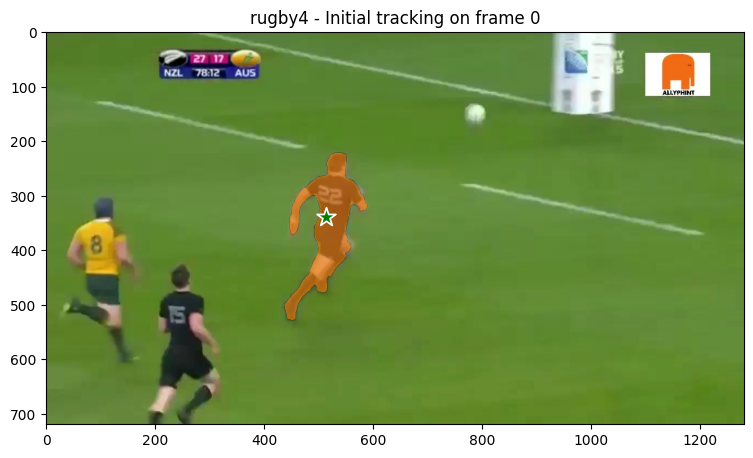

Propagating tracking for rugby4...


propagate in video: 100%|██████████| 44/44 [05:09<00:00,  7.03s/it]


Completed tracking for rugby4: 44 frames processed


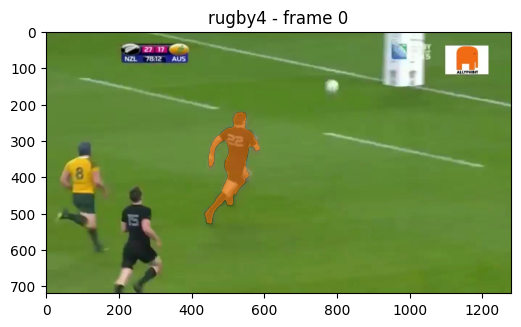

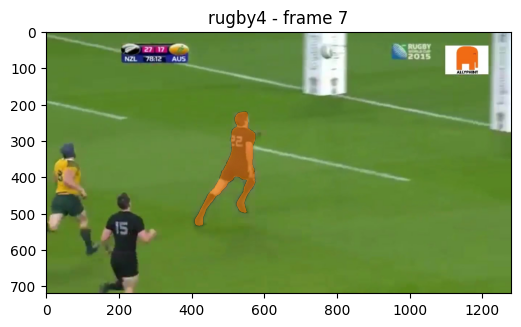

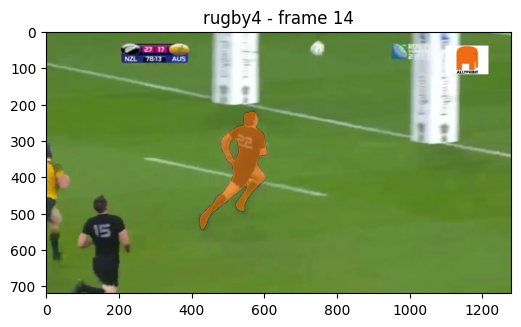

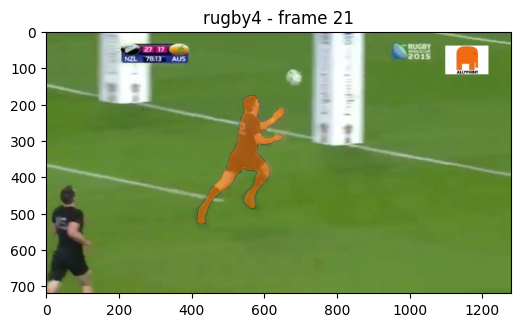

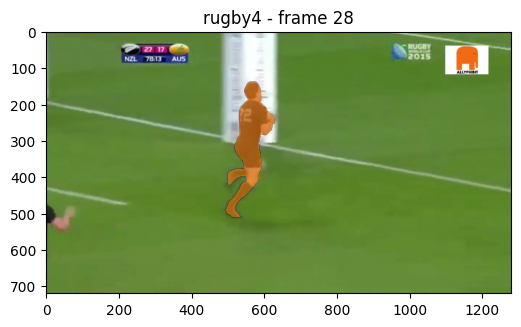

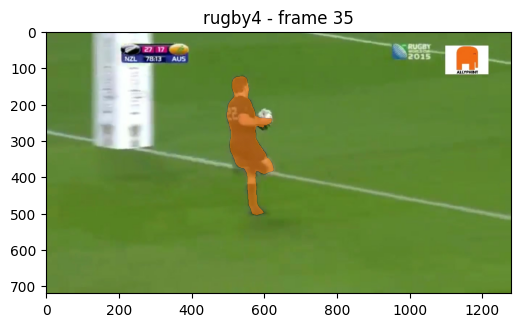

Saving rugby4 video...
❌ Error processing rugby4: boolean index did not match indexed array along axis 0; size of axis is 720 but size of corresponding boolean axis is 1
----------------------------------------
🎉 All rugby scenes processing completed!
Successfully processed: 4 out of 4 scenes
Videos saved: []
Total frames processed across all scenes: 461


In [26]:
# Process all 4 rugby scenes
scene_results = {}
saved_videos = []

print("🚀 Starting processing of 4 rugby scenes...")
print("=" * 60)

for scene_name, scene_config in rugby_scenes.items():
    try:
        # Process the scene
        result = process_rugby_scene(scene_name, scene_config, predictor, device)
        
        if result is not None:
            # Store result
            scene_results[scene_name] = result
            
            # Save the video immediately after processing
            video_path = save_rugby_scene_video(result)
            if video_path:
                saved_videos.append(video_path)
            
            print(f"✅ Completed {scene_name}")
        else:
            print(f"❌ Failed to process {scene_name}")
            
        print("-" * 40)
        
    except Exception as e:
        print(f"❌ Error processing {scene_name}: {str(e)}")
        print("-" * 40)
        continue

print("🎉 All rugby scenes processing completed!")
print(f"Successfully processed: {len(scene_results)} out of {len(rugby_scenes)} scenes")
print(f"Videos saved: {saved_videos}")

# Summary statistics
total_frames = sum(len(result["video_segments"]) for result in scene_results.values())
print(f"Total frames processed across all scenes: {total_frames}")

In [28]:
def save_rugby_scene_video(scene_result, output_fps=30.0):
    """
    Save a rugby scene with segmentation masks as a video file
    Enhanced version with robust dimension handling
    """
    if scene_result is None:
        print("❌ No scene result provided")
        return None
    
    scene_name = scene_result["scene_name"]
    video_segments = scene_result["video_segments"]
    frame_names = scene_result["frame_names"]
    video_dir = scene_result["video_dir"]
    
    output_path = f"{scene_name}_segmentation.mp4"
    
    # Import cv2 if not already imported
    try:
        import cv2
    except ImportError:
        print("OpenCV not found. Installing...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python"])
        import cv2
    
    # Get first frame to determine video properties
    first_frame_path = os.path.join(video_dir, frame_names[0])
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        print(f"❌ Could not read first frame from {first_frame_path}")
        return None
        
    height, width, channels = first_frame.shape
    print(f"📐 Video dimensions: {width}x{height}")
    
    # Try different codecs for better compatibility
    codecs_to_try = [
        ('mp4v', '.mp4'),
        ('XVID', '.avi'),
        ('MJPG', '.avi')
    ]
    
    out = None
    final_output_path = None
    
    for codec, ext in codecs_to_try:
        try:
            test_output_path = f"{scene_name}_segmentation{ext}"
            fourcc = cv2.VideoWriter_fourcc(*codec)
            out = cv2.VideoWriter(test_output_path, fourcc, output_fps, (width, height))
            
            if out.isOpened():
                final_output_path = test_output_path
                print(f"✅ Using codec: {codec}")
                break
            else:
                out.release()
                out = None
        except Exception as e:
            print(f"⚠️ Failed to initialize codec {codec}: {e}")
            if out:
                out.release()
                out = None
    
    if out is None or not out.isOpened():
        print("❌ Could not initialize any video codec")
        return None
    
    print(f"🎥 Saving {scene_name} video to {final_output_path}...")
    frames_written = 0
    
    try:
        for frame_idx in range(len(frame_names)):
            # Read original frame
            frame_path = os.path.join(video_dir, frame_names[frame_idx])
            frame = cv2.imread(frame_path)
            
            if frame is None:
                print(f"⚠️ Could not read frame {frame_idx} from {frame_path}, skipping...")
                continue
            
            # Ensure frame has correct dimensions
            if frame.shape[:2] != (height, width):
                frame = cv2.resize(frame, (width, height))
            
            # Add masks if available for this frame
            if frame_idx in video_segments:
                for obj_id, mask in video_segments[frame_idx].items():
                    try:
                        # Convert mask to numpy array if it's not already
                        mask = np.array(mask)
                        
                        # Handle different mask dimensions
                        if mask.ndim > 2:
                            # If mask has extra dimensions, squeeze them
                            mask = np.squeeze(mask)
                        
                        # Ensure mask is 2D
                        if mask.ndim != 2:
                            print(f"⚠️ Unexpected mask dimensions: {mask.shape}, skipping...")
                            continue
                        
                        # Get mask dimensions
                        mask_h, mask_w = mask.shape
                        
                        # Resize mask to match frame dimensions if needed
                        if (mask_h, mask_w) != (height, width):
                            print(f"🔄 Resizing mask from {mask.shape} to ({height}, {width})")
                            # Convert to uint8 for resize, then back to bool
                            mask_uint8 = (mask * 255).astype(np.uint8)
                            mask_resized = cv2.resize(mask_uint8, (width, height), interpolation=cv2.INTER_NEAREST)
                            mask = (mask_resized > 127).astype(bool)  # Convert back to boolean
                        
                        # Double check dimensions match
                        if mask.shape != (height, width):
                            print(f"⚠️ Mask shape {mask.shape} still doesn't match frame shape ({height}, {width}), skipping...")
                            continue
                        
                        # Create colored mask overlay
                        cmap = plt.get_cmap("tab10")
                        color = np.array([*cmap(obj_id % 10)[:3]])  # Ensure obj_id is within colormap range
                        
                        # Create mask overlay using numpy indexing (safer approach)
                        mask_colored = np.zeros((height, width, 3), dtype=np.uint8)
                        
                        # Apply color where mask is True using proper indexing
                        mask_indices = np.where(mask)
                        if len(mask_indices[0]) > 0:  # Check if mask has any True values
                            # Convert color from RGB to BGR for OpenCV
                            bgr_color = (color[::-1] * 255).astype(np.uint8)
                            mask_colored[mask_indices[0], mask_indices[1]] = bgr_color
                            
                            # Blend with original frame
                            frame = cv2.addWeighted(frame, 0.6, mask_colored, 0.4, 0)
                        
                    except Exception as e:
                        print(f"⚠️ Error applying mask for frame {frame_idx}, obj {obj_id}: {str(e)}")
                        print(f"   Mask shape: {mask.shape if 'mask' in locals() else 'unknown'}")
                        print(f"   Frame shape: {frame.shape}")
                        continue
            
            # Write frame
            success = out.write(frame)
            if success:
                frames_written += 1
            else:
                print(f"⚠️ Failed to write frame {frame_idx}")
                
            # Progress indicator
            if frame_idx % 50 == 0:
                print(f"📊 Progress: {frame_idx}/{len(frame_names)} frames")
    
    except Exception as e:
        print(f"❌ Error during video creation: {str(e)}")
        return None
    
    finally:
        out.release()
    
    # Verify the output file was created
    if os.path.exists(final_output_path) and os.path.getsize(final_output_path) > 0:
        print(f"✅ Video saved successfully: {final_output_path}")
        print(f"📊 Frames written: {frames_written}/{len(frame_names)}")
        return final_output_path
    else:
        print(f"❌ Video file creation failed or file is empty")
        return None

print("✅ Enhanced save_rugby_scene_video function loaded!")

✅ Enhanced save_rugby_scene_video function loaded!


In [29]:
# Re-save videos with the improved function
print("🔄 Re-saving videos with the enhanced function...")
print("=" * 50)

if 'scene_results' in locals() and scene_results:
    print(f"Found {len(scene_results)} processed scenes:")
    for scene_name in scene_results.keys():
        print(f"  - {scene_name}")
    
    # Re-save videos for all processed scenes
    new_saved_videos = []
    
    for scene_name, result in scene_results.items():
        try:
            print(f"\n🎥 Re-saving video for {scene_name}...")
            video_path = save_rugby_scene_video(result)
            if video_path:
                new_saved_videos.append(video_path)
                print(f"✅ Successfully saved: {video_path}")
            else:
                print(f"❌ Failed to save video for {scene_name}")
                
        except Exception as e:
            print(f"❌ Error saving video for {scene_name}: {str(e)}")
            continue
    
    print("\n" + "=" * 50)
    print("🎉 Video re-saving completed!")
    print(f"Videos successfully saved: {len(new_saved_videos)}")
    print(f"New video files: {new_saved_videos}")
    
else:
    print("❌ No processed scene results found.")
    print("The processing cell needs to be run first.")

🔄 Re-saving videos with the enhanced function...
Found 4 processed scenes:
  - rugby1
  - rugby2
  - rugby3
  - rugby4

🎥 Re-saving video for rugby1...
📐 Video dimensions: 1280x720
✅ Using codec: mp4v
🎥 Saving rugby1 video to rugby1_segmentation.mp4...
⚠️ Failed to write frame 0
📊 Progress: 0/120 frames
⚠️ Failed to write frame 1
⚠️ Failed to write frame 2
⚠️ Failed to write frame 3
⚠️ Failed to write frame 4
⚠️ Failed to write frame 5
⚠️ Failed to write frame 6
⚠️ Failed to write frame 7
⚠️ Failed to write frame 8
⚠️ Failed to write frame 9
⚠️ Failed to write frame 10
⚠️ Failed to write frame 11
⚠️ Failed to write frame 12
⚠️ Failed to write frame 13
⚠️ Failed to write frame 14
⚠️ Failed to write frame 15
⚠️ Failed to write frame 16
⚠️ Failed to write frame 17
⚠️ Failed to write frame 18
⚠️ Failed to write frame 19
⚠️ Failed to write frame 20
⚠️ Failed to write frame 21
⚠️ Failed to write frame 22
⚠️ Failed to write frame 23
⚠️ Failed to write frame 24
⚠️ Failed to write frame 25
⚠️ F

In [30]:
def merge_rugby_videos(video_files, output_filename="merged_rugby_segmentation.mp4", transition_type="fade", transition_duration=0.5):
    """
    Merge multiple rugby segmentation videos into a single video
    
    Parameters:
    - video_files: List of video file paths to merge
    - output_filename: Name of the output merged video
    - transition_type: Type of transition ('fade', 'cut', 'slide')
    - transition_duration: Duration of transition in seconds (for fade transitions)
    """
    try:
        import cv2
    except ImportError:
        print("Installing OpenCV...")
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python"])
        import cv2
    
    # Check which video files exist
    existing_files = []
    missing_files = []
    
    for video_file in video_files:
        if os.path.exists(video_file):
            existing_files.append(video_file)
            print(f"✅ Found: {video_file}")
        else:
            missing_files.append(video_file)
            print(f"❌ Missing: {video_file}")
    
    if not existing_files:
        print("❌ No video files found to merge!")
        return None
    
    if missing_files:
        print(f"⚠️ Proceeding with {len(existing_files)} available videos")
    
    # Get video properties from the first video
    cap = cv2.VideoCapture(existing_files[0])
    
    if not cap.isOpened():
        print(f"❌ Cannot open first video: {existing_files[0]}")
        return None
    
    # Get properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    cap.release()
    
    print(f"📐 Video properties: {width}x{height} @ {fps} FPS")
    
    # Create output video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))
    
    if not out.isOpened():
        print("❌ Failed to create output video writer")
        return None
    
    total_frames_written = 0
    transition_frames = int(fps * transition_duration)
    
    print(f"🎬 Starting to merge {len(existing_files)} videos...")
    print(f"🔄 Using '{transition_type}' transitions with {transition_duration}s duration")
    
    for i, video_file in enumerate(existing_files):
        print(f"\n📹 Processing video {i+1}/{len(existing_files)}: {video_file}")
        
        cap = cv2.VideoCapture(video_file)
        if not cap.isOpened():
            print(f"⚠️ Cannot open {video_file}, skipping...")
            continue
        
        frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_written_this_video = 0
        
        # Read all frames from current video
        current_video_frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Resize frame if dimensions don't match
            if frame.shape[:2] != (height, width):
                frame = cv2.resize(frame, (width, height))
            
            current_video_frames.append(frame)
        
        cap.release()
        
        print(f"📊 Loaded {len(current_video_frames)} frames from {video_file}")
        
        # Add transition effects
        if i > 0 and transition_type == "fade" and len(current_video_frames) > 0:
            # Create fade transition
            print(f"🎭 Adding fade transition...")
            
            # Fade out previous video's last frames (if we have them)
            # Fade in current video's first frames
            fade_frames = min(transition_frames, len(current_video_frames) // 2)
            
            for fade_idx in range(fade_frames):
                alpha = fade_idx / fade_frames  # 0 to 1
                
                if fade_idx < len(current_video_frames):
                    frame = current_video_frames[fade_idx]
                    # Apply fade in effect
                    faded_frame = (frame * alpha).astype(np.uint8)
                    out.write(faded_frame)
                    frames_written_this_video += 1
            
            # Write remaining frames normally (skip the faded ones)
            start_idx = fade_frames
        else:
            start_idx = 0
        
        # Write the rest of the frames
        for frame_idx in range(start_idx, len(current_video_frames)):
            frame = current_video_frames[frame_idx]
            
            # Apply fade out effect for last frames if this is not the last video
            if (i < len(existing_files) - 1 and 
                transition_type == "fade" and 
                frame_idx >= len(current_video_frames) - transition_frames):
                
                fade_progress = (len(current_video_frames) - frame_idx) / transition_frames
                alpha = max(0, min(1, fade_progress))  # 1 to 0
                frame = (frame * alpha).astype(np.uint8)
            
            out.write(frame)
            frames_written_this_video += 1
        
        total_frames_written += frames_written_this_video
        print(f"✅ Written {frames_written_this_video} frames from {video_file}")
    
    out.release()
    
    # Verify output file
    if os.path.exists(output_filename) and os.path.getsize(output_filename) > 0:
        print(f"\n🎉 Successfully merged videos!")
        print(f"📁 Output file: {output_filename}")
        print(f"📊 Total frames written: {total_frames_written}")
        print(f"⏱️ Estimated duration: {total_frames_written / fps:.2f} seconds")
        return output_filename
    else:
        print("❌ Failed to create merged video")
        return None


# Execute the merge
print("🚀 Starting video merge process...")
print("=" * 60)

# Define the video files to merge (in order)
rugby_video_files = [
    "rugby1_segmentation.mp4",
    "rugby2_segmentation.mp4", 
    "rugby3_segmentation.mp4",
    "rugby4_segmentation.mp4"
]

# Also try alternative extensions
alternative_files = [
    "rugby1_segmentation.avi",
    "rugby2_segmentation.avi",
    "rugby3_segmentation.avi", 
    "rugby4_segmentation.avi"
]

# Check for existing files
print("🔍 Checking for video files...")
available_files = []

for mp4_file, avi_file in zip(rugby_video_files, alternative_files):
    if os.path.exists(mp4_file):
        available_files.append(mp4_file)
    elif os.path.exists(avi_file):
        available_files.append(avi_file)

print(f"Found {len(available_files)} video files to merge")

if available_files:
    # Merge with fade transitions
    merged_video_fade = merge_rugby_videos(
        available_files, 
        "merged_rugby_segmentation_fade.mp4",
        transition_type="fade",
        transition_duration=0.5
    )
    
    # Merge with simple cuts (no transitions)  
    merged_video_cut = merge_rugby_videos(
        available_files,
        "merged_rugby_segmentation_cut.mp4", 
        transition_type="cut",
        transition_duration=0
    )
    
    print("\n" + "=" * 60)
    print("✅ Video merging completed!")
    
    if merged_video_fade:
        print(f"🎬 Fade transition version: {merged_video_fade}")
    if merged_video_cut:
        print(f"🎬 Cut transition version: {merged_video_cut}")
        
else:
    print("❌ No rugby segmentation videos found!")
    print("Make sure the rugby segmentation videos have been generated first.")
    print("Expected files:")
    for file in rugby_video_files:
        print(f"  - {file}")

🚀 Starting video merge process...
🔍 Checking for video files...
Found 4 video files to merge
✅ Found: rugby1_segmentation.mp4
✅ Found: rugby2_segmentation.mp4
✅ Found: rugby3_segmentation.mp4
✅ Found: rugby4_segmentation.mp4
📐 Video properties: 1280x720 @ 30 FPS
🎬 Starting to merge 4 videos...
🔄 Using 'fade' transitions with 0.5s duration

📹 Processing video 1/4: rugby1_segmentation.mp4
📊 Loaded 120 frames from rugby1_segmentation.mp4
📊 Loaded 120 frames from rugby1_segmentation.mp4
✅ Written 120 frames from rugby1_segmentation.mp4

📹 Processing video 2/4: rugby2_segmentation.mp4
✅ Written 120 frames from rugby1_segmentation.mp4

📹 Processing video 2/4: rugby2_segmentation.mp4
📊 Loaded 105 frames from rugby2_segmentation.mp4
🎭 Adding fade transition...
📊 Loaded 105 frames from rugby2_segmentation.mp4
🎭 Adding fade transition...
✅ Written 105 frames from rugby2_segmentation.mp4

📹 Processing video 3/4: rugby3_segmentation.mp4
✅ Written 105 frames from rugby2_segmentation.mp4

📹 Processi